# Abstract dataset
In this notebook we will train VAIR on the abstract dataset presented in Section 3.1 of our manuscript. We will then reproduce with this example model the panels presented in Figure 2 of the manuscript.

## Dataset generation
We start by defining the parameters of the dataset and generating it. In particular, we consider an abstract dataset with $N_c=4$ hidden factors $c$, observations $x$ with $d_x = 10$, and outputs $y$ with dimension $d_y=10$. Last, we consider that actions represented by a one hot enconding of dimension $d_a=2$. For further details on the dataset please check he manuscript.

In [1]:
from air.datasets.abstract_exp import dataset_abstract

# Dataset parameters
num_c = 4
dim_x = 10
dim_y = 10
dim_a = 2
device = 'cuda'

# Seed function for the random functions
seed_funcs= 1110

data, loader_test, loader = dataset_abstract(N = 3000,
                                            num_c = num_c,
                                            dim_x= dim_x,
                                            dim_y = dim_y,
                                            size_train = 0.8,
                                            BS = 100, seed_funcs= seed_funcs, device = device)

## VAIR training
We now define the VAIR architecture and train it on the abstract dataset. We consider a latent space of dimension $d_z=6$ as used in the manuscript. 

In [2]:
from air.models import VAIR
dim_z = 6
epochs = 300
lr, beta = (1e-4, 0.001)

# Set random seed for reproducibility
import torch
torch.manual_seed(0)

vair = VAIR(dim_x = dim_x, # Dimension input to encoder
             dim_z = dim_z, # Dimension latent
             dim_a = dim_a, # Dimension action representation               
             dim_y = dim_y,
).to(device)

We use the fastai library to train the model. As loss, we consider the usual $\beta$-VAE loss with reconstruction objective given by the mean squared error (MSE). We also use a custom callbacks to save the values of the log-variances of the latent variables over epochs.

In [3]:
from fastai.vision.all import Learner, Adam
from air.losses_metrics import beta_mse_loss, save_logvars

learn_vair = Learner(data, 
                     vair,
                     loss_func = beta_mse_loss(loss_objective = 'H',
                                               beta = beta,
                                               recon_objective='mse'), 
                     opt_func= Adam,
                     cbs = (save_logvars())     
                    )


with learn_vair.no_logging(): learn_vair.fit(epochs, lr = lr)

## Analysis

### Variances over epochs
We start by showing the evolution of the log-variances over epochs. In particular, we see how the neurons separate into active, passive and mixed ones, with the passive ones having higher log-variances (dashed lines). See the manuscript for more details.

''

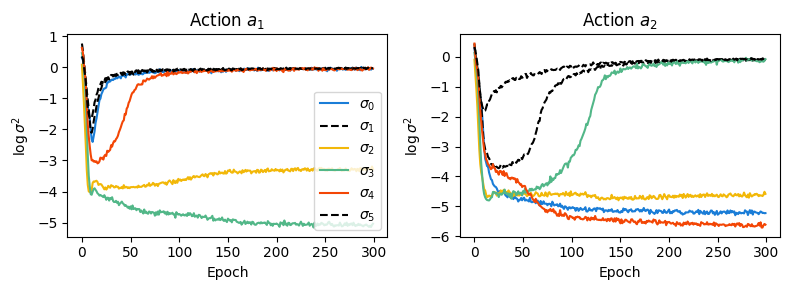

In [4]:
import matplotlib.pyplot as plt

# From the previous seed, the passive neurons are 1 and 5. Note that changing the seed will change this.
passive = [1, 5]

fig, ax = plt.subplots(1,2, figsize = (8,3), tight_layout = True)

for idx in range(2):
    colors = iter(['#1a7dd7ff', '#f2b809ff',  '#52b788', '#f34605ff'])
    
    for z in range(learn_vair.dim_z):          

        # For each action and for each latent variable, plot the log-variance evolution
        ax[idx].plot(learn_vair.save_logvars.logvars[:, idx, z].detach().cpu(), 
                     c = next(colors) if z not in passive else 'k', 
                     label = f'$\sigma_{z}$', 
                     ls = '-' if z not in passive else '--');
        
    ax[idx].set_title(f'Action $a_{idx+1}$')

ax[0].legend()
plt.setp(ax, xlabel = 'Epoch', ylabel = r'$\log \sigma^2$')
;

Similar to what is shown in the manuscript: two neurons are passive ($\sigma_{1,5}$); three neurons are mixed, i.e., only active for one action ($\sigma_3$ and $\sigma_{0,4}$ respectively for each action); and one active neuron ($\sigma_2$).

### Observation representation in the latent space
Thanks to its dual encoder, it is very easy to analyze how the observations $x$ are represented in the latent space $z$. In particular, we can generate observations by varying one hidden factor $c$ at a time, and then encoding them to see how the latent variables respond to changes in each hidden factor. As shown in the manuscript and the results shown above, we expect that neuron 2 will encode a disentangled representation of hidden factor $c_2$. On the other hand, mixed neurons will encode entangled representations of the rest of the hidden factors $c$.

[Text(0, 0.5, '$c$')]

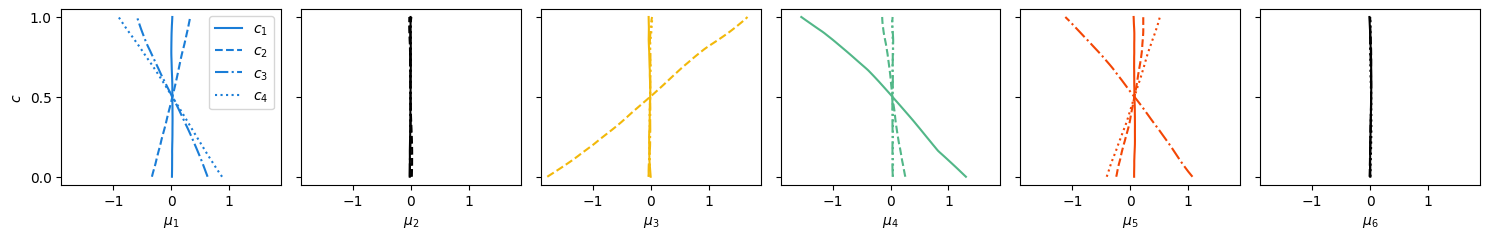

In [5]:
from air.datasets.abstract_exp import random_functions

fig, axes = plt.subplots(1, learn_vair.dim_z, figsize=(learn_vair.dim_z*2.5, 2.5), tight_layout=False) 
line_styles = ['-', '--', '-.', ':']
N = 100

for idxh in range(4):

    # We generate the value of the factors such that only factor idxh varies from 0 to 1
    h = torch.ones(N,4)*0.5
    h[:, idxh] = torch.linspace(0, 1, N)
    inp = random_functions(h.clone(), dim_x, seed_funcs)   

    # We then compute the latent means from the E_x encoder
    mus = learn_vair.E_x(inp.to(device)).detach().cpu()    

    colors = iter(['#1a7dd7ff', '#f2b809ff',  '#52b788', '#f34605ff'])
    for idxm, (m, ax) in enumerate(zip(mus.T, axes)):
        
        ax.plot(m, h[:, idxh], 
                label = fr'$c_{idxh+1}$', 
                c = 'k' if idxm in passive else next(colors), 
                ls = line_styles[idxh]);

        if idxh == 0:
            ax.set_xlabel(f'$\mu_{idxm+1}$')

axes[0].legend()
plt.setp(axes, xlim = (-1.9, 1.9), yticks = [0,0.5,1]);
plt.setp(axes[1:], yticklabels = [])
plt.setp(axes[0], ylabel = r'$c$')

As we can see, the presented results match the observations of our manuscripts. Feel free to change the seeds to observe different configurations of active, passive and mixed neurons. Note that in that case you will need to change the indices of the passive neurons in the plotting code above!